# AutoML

Escogiendo una base de datos generica como puede ser IRIS o alguna otra, se realizaran entrenamientos de forma manual como random forest, clustering o otros metodos y seran comparados con los resultados de AutoML. 

Se utilizaran hyperparametros para ajustar al maximo el modelo para obtener los mejores resultados.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel

## Preparacion de los datos

Para realizar la comparacion y ver la importancia de los hiperparametros, he escogido un dataset generico como es Breast cancer. Este dataset esta compuesto por un total de 569 muestras entre las cuales se distinguen 2 clases que son malignant y benign.

In [2]:
data = datasets.load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Analizando los atributos de este dataset tenemos 30 atributos numericos y por ultimo la clase a la que corresponde esa muestra. (['malignant' 'benign'])

In [3]:
print (data.target_names)
class_names = data.target_names
df.head()

['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# Comprovaremos y trataremos los valores nulos 
df.isnull().values.any()

False

In [5]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [6]:
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3 ,random_state=1)


## Decision Tree Classifier

Visualizando los parametros por defecto se han seleccionado tres que seran los hyperparametros que modificaremos para poder ajustar nuestro modelo lo mejor posible. Estos tres parametros son: el criterio, la profundidad máxima del arbol y el número de caracteristicas.

### Valores por defecto

In [7]:
dtree = DecisionTreeClassifier()

# Miramos los parametros por defecto
def_tree_hparams = dtree.get_params()
print("*************** Parametros por defecto *******************")
print("Criterio--> "+def_tree_hparams['criterion'])
print("Profundidad max.--> "+str(def_tree_hparams['max_depth']))
print("Caracteristicas max.--> "+str(def_tree_hparams['max_features']))

*************** Parametros por defecto *******************
Criterio--> gini
Profundidad max.--> None
Caracteristicas max.--> None


In [8]:
dtree2 = dtree.fit(X_train,y_train)
y_pred_tree = dtree2.predict(X_test)
accuracy_tree_df = metrics.accuracy_score(y_test, y_pred_tree)

print("Accuracy:",accuracy_tree_df)


Accuracy: 0.9415204678362573


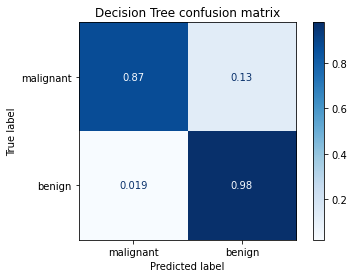

In [65]:
disp = metrics.plot_confusion_matrix(dtree,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Decision Tree confusion matrix")
plt.savefig("graficas/decisionTree-matriz.jpg")
plt.show()

### Modificacion hyperparametros

In [10]:
tree_hparams = {'criterion': ["gini","entropy"],"max_depth":[2,3,4,5],"max_features":[2,3,4]}

In [11]:
tree_cv = GridSearchCV(estimator=dtree, param_grid= tree_hparams,cv=10)
tree_cv.fit(X,y)
print(tree_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 3}


In [12]:
tree_new_mean = tree_cv.cv_results_["mean_test_score"][tree_cv.best_index_]
tree_new_std = tree_cv.cv_results_["std_test_score"][tree_cv.best_index_]

print("%0.4f accuracy con una desviacion estandar de %0.4f" % (tree_new_mean, tree_new_std))

0.9438 accuracy con una desviacion estandar de 0.0269


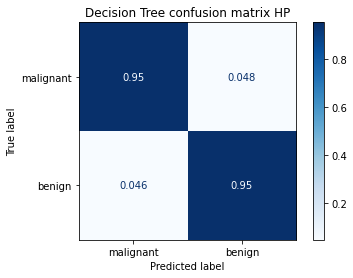

In [13]:
disp = metrics.plot_confusion_matrix(tree_cv,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Decision Tree confusion matrix HP")
plt.show()

## Random Forest Classifier

### Valores por defecto

In [14]:
dforest = RandomForestClassifier()

# Miramos los parametros por defecto
def_forest_hparams = dforest.get_params()
print("*************** Parametros por defecto *******************")
print("Criterio--> "+def_forest_hparams['criterion'])
print("Profundidad max.--> "+str(def_forest_hparams['max_depth']))
print("Caracteristicas max.--> "+str(def_forest_hparams['max_features']))
print("N estimators--> "+str(def_forest_hparams['n_estimators']))

*************** Parametros por defecto *******************
Criterio--> gini
Profundidad max.--> None
Caracteristicas max.--> auto
N estimators--> 100


In [15]:
dforest2 = dforest.fit(X_train,y_train)
y_pred_forest = dforest2.predict(X_test)
accuracy_forest_df = metrics.accuracy_score(y_test, y_pred_forest)

print("Accuracy:",accuracy_forest_df)

Accuracy: 0.9532163742690059


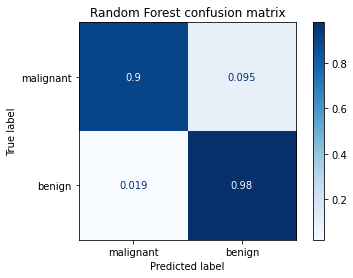

In [64]:
disp = metrics.plot_confusion_matrix(dforest,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Random Forest confusion matrix")
plt.savefig("graficas/randomForest-matriz.jpg")
plt.show()

### Modificacion hyperparametros

In [17]:
forest_hparams = {'criterion': ["gini","entropy"],"max_depth":[2,3,4,5],"max_features":[2,3,4],"n_estimators" : [20, 30, 40, 50]}

In [18]:
forest_cv = GridSearchCV(estimator=dforest, param_grid= forest_hparams,cv=10)
forest_cv.fit(X,y)
print(forest_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'n_estimators': 20}


In [19]:
forest_new_mean = forest_cv.cv_results_["mean_test_score"][forest_cv.best_index_]
forest_new_std = forest_cv.cv_results_["std_test_score"][forest_cv.best_index_]

print("%0.4f accuracy con una desviacion estandar de %0.4f" % (forest_new_mean, forest_new_std))

0.9684 accuracy con una desviacion estandar de 0.0233


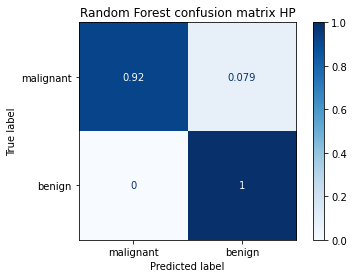

In [20]:
disp = metrics.plot_confusion_matrix(forest_cv,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Random Forest confusion matrix HP")
plt.show()

## KNN

### Valores por defecto

In [21]:
dknn = KNeighborsClassifier()

# Miramos los parametros por defecto
def_knn_hparams = dknn.get_params()
print("*************** Parametros por defecto *******************")
print("Vecinos --> "+str(def_knn_hparams['n_neighbors']))
print("Pesos --> "+str(def_knn_hparams['weights']))
print("P --> "+str(def_knn_hparams['p'])+" (1 distancia manhattan, 2 distancia euclideana)")

*************** Parametros por defecto *******************
Vecinos --> 5
Pesos --> uniform
P --> 2 (1 distancia manhattan, 2 distancia euclideana)


In [22]:
dknn2 = dknn.fit(X_train,y_train)
y_pred_knn = dknn2.predict(X_test)
accuracy_knn_df = metrics.accuracy_score(y_test, y_pred_knn)

print("Accuracy:",accuracy_knn_df)

Accuracy: 0.9298245614035088


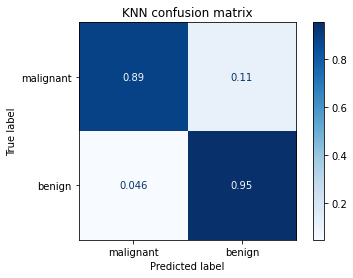

In [63]:
disp = metrics.plot_confusion_matrix(dknn,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("KNN confusion matrix")
plt.savefig("graficas/knn-matriz.jpg")
plt.show()

### Modificacion hyperparametros

In [24]:
knn_hparams = {'n_neighbors': list(range(1,20)),"p":[1,2],"weights":['distance','uniform']}

In [25]:
knn_cv = GridSearchCV(estimator=dknn, param_grid= knn_hparams,cv=10)
knn_cv.fit(X,y)
print(knn_cv.best_params_)

{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}


In [26]:
knn_new_mean = knn_cv.cv_results_["mean_test_score"][knn_cv.best_index_]
knn_new_std = knn_cv.cv_results_["std_test_score"][knn_cv.best_index_]

print("%0.4f accuracy con una desviacion estandar de %0.4f" % (knn_new_mean, knn_new_std))

0.9420 accuracy con una desviacion estandar de 0.0249


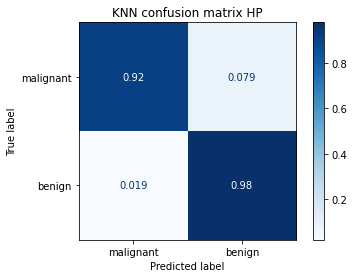

In [27]:
disp = metrics.plot_confusion_matrix(knn_cv,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("KNN confusion matrix HP")
plt.show()

## MLP

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=[100,100], alpha = 5, solver = 'adam', max_iter = 5000, epsilon=1e-08)

mlp_model = mlp.fit(X_train,y_train)

y_pred_mlp = mlp_model.predict(X_test)
accuracy_mlp_df = metrics.accuracy_score(y_test, y_pred_mlp)

print("Accuracy:",accuracy_mlp_df)

Accuracy: 0.935672514619883


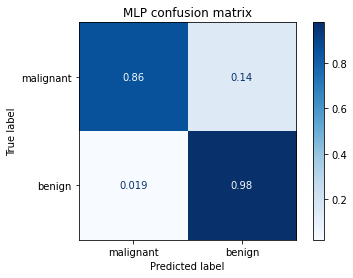

In [62]:
disp = metrics.plot_confusion_matrix(mlp_model,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("MLP confusion matrix")
plt.savefig("graficas/mlp-matriz.jpg")
plt.show()

### Modificacion hyperparametros

In [30]:
mlp_param = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [1e-4, 1e-3, 0.01, 0.1, 1]
}

In [31]:
mlp_cv = GridSearchCV(MLPClassifier(hidden_layer_sizes=[100,100],max_iter=5000,random_state=42), mlp_param, n_jobs=-1, cv=3)

In [32]:
mlp_cv.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=MLPClassifier(hidden_layer_sizes=[100, 100],
                                     max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'solver': ['sgd', 'adam']})

In [33]:
print(mlp_cv.best_params_)

{'activation': 'tanh', 'alpha': 1, 'solver': 'adam'}


In [34]:
mlp_new_mean = mlp_cv.cv_results_["mean_test_score"][mlp_cv.best_index_]
mlp_new_std = mlp_cv.cv_results_["std_test_score"][mlp_cv.best_index_]
print("%0.4f accuracy con una desviacion estandar de %0.4f" % (mlp_new_mean, mlp_new_std))

0.9372 accuracy con una desviacion estandar de 0.0197


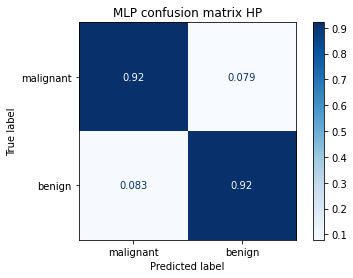

In [35]:
disp = metrics.plot_confusion_matrix(mlp_cv,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("MLP confusion matrix HP")
plt.show()

## Proceso Gaussiano

In [36]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel, max_iter_predict=5000, n_jobs=-1)

gpc_model = gpc.fit(X_train,y_train)

y_pred_gpc = gpc_model.predict(X_test)
accuracy_gpc_df = metrics.accuracy_score(y_test, y_pred_gpc)

print("Accuracy:",accuracy_gpc_df)

Accuracy: 0.9415204678362573


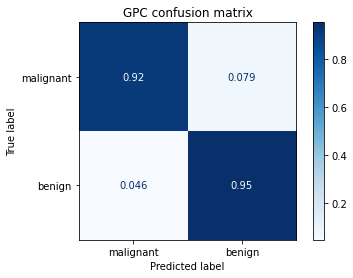

In [60]:
disp = metrics.plot_confusion_matrix(gpc_model,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("GPC confusion matrix")
plt.savefig("graficas/gpc-matriz.jpg")
plt.show()

In [38]:
gpc_param = {
    'kernel': [1*RBF(), 1*DotProduct(), 1*Matern(), 1*RationalQuadratic(), 1*WhiteKernel()],
}

In [39]:
gpc_cv = GridSearchCV(GaussianProcessClassifier(max_iter_predict=5000), gpc_param, n_jobs=-1, cv=3)

In [40]:
gpc_cv.fit(X_train,y_train)

/home/japicazos/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/japicazos/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/japicazos/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

GridSearchCV(cv=3, estimator=GaussianProcessClassifier(max_iter_predict=5000),
             n_jobs=-1,
             param_grid={'kernel': [1**2 * RBF(length_scale=1),
                                    1**2 * DotProduct(sigma_0=1),
                                    1**2 * Matern(length_scale=1, nu=1.5),
                                    1**2 * RationalQuadratic(alpha=1, length_scale=1),
                                    1**2 * WhiteKernel(noise_level=1)]})

In [41]:
print(gpc_cv.best_params_)

{'kernel': 1**2 * DotProduct(sigma_0=1)}


In [42]:
gpc_new_mean = gpc_cv.cv_results_["mean_test_score"][gpc_cv.best_index_]
gpc_new_std = gpc_cv.cv_results_["std_test_score"][gpc_cv.best_index_]
print("%0.4f accuracy con una desviacion estandar de %0.4f" % (gpc_new_mean, gpc_new_std))

0.9548 accuracy con una desviacion estandar de 0.0221


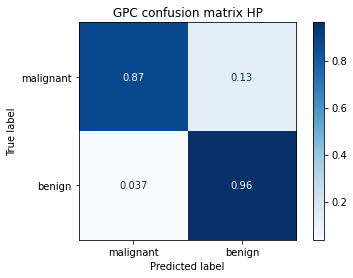

In [43]:
disp = metrics.plot_confusion_matrix(gpc_cv,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("GPC confusion matrix HP")
plt.show()

# AutoSklearn

In [44]:
import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

/home/japicazos/.local/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [45]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    metric=autosklearn.metrics.accuracy,
    resampling_strategy='holdout',
    resampling_strategy_arguments={'train_size': 0.70}
)
    
automl.fit(X_train, y_train)

AutoSklearnClassifier(metric=accuracy, per_run_time_limit=30,
                      resampling_strategy_arguments={'train_size': 0.7},
                      time_left_for_this_task=120)

In [46]:
predictions = automl.predict(X_test)
accuracy_automl = metrics.accuracy_score(y_test, predictions)
print("Accuracy score:", accuracy_automl )

Accuracy score: 0.9473684210526315


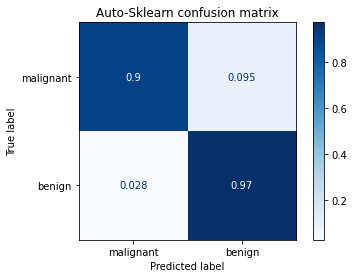

In [61]:
disp = metrics.plot_confusion_matrix(automl,X_test,y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Auto-Sklearn confusion matrix")
plt.savefig("graficas/autoSklearn-matriz.jpg")
plt.show()

In [48]:
automl.score(X_train,y_train)

0.9974874371859297

In [49]:
automl.score(X_test,y_test)

0.9473684210526315

In [50]:
automl.get_params()

{'dask_client': None,
 'delete_output_folder_after_terminate': True,
 'delete_tmp_folder_after_terminate': True,
 'disable_evaluator_output': False,
 'ensemble_nbest': 50,
 'ensemble_size': 50,
 'exclude_estimators': None,
 'exclude_preprocessors': None,
 'get_smac_object_callback': None,
 'include_estimators': None,
 'include_preprocessors': None,
 'initial_configurations_via_metalearning': 25,
 'load_models': True,
 'logging_config': None,
 'max_models_on_disc': 50,
 'memory_limit': 3072,
 'metadata_directory': None,
 'metric': accuracy,
 'n_jobs': None,
 'output_folder': None,
 'per_run_time_limit': 30,
 'resampling_strategy': 'holdout',
 'resampling_strategy_arguments': {'train_size': 0.7},
 'scoring_functions': None,
 'seed': 1,
 'smac_scenario_args': None,
 'time_left_for_this_task': 120,
 'tmp_folder': None}

In [51]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: a8386fd5-a405-11eb-8a01-4f53c0c50edc
  Metric: accuracy
  Best validation score: 0.983333
  Number of target algorithm runs: 50
  Number of successful target algorithm runs: 49
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



In [52]:
losses_and_configurations = [
    (run_value.cost, run_key.config_id)
    for run_key, run_value in automl.automl_.runhistory_.data.items()
]
losses_and_configurations.sort()
print("Lowest loss:", losses_and_configurations[0][0])
print(
    "Best configuration:",
    automl.automl_.runhistory_.ids_config[losses_and_configurations[0][1]]
)

Lowest loss: 0.01666666666666672
Best configuration: Configuration:
  balancing:strategy, Value: 'weighting'
  classifier:__choice__, Value: 'mlp'
  classifier:mlp:activation, Value: 'tanh'
  classifier:mlp:alpha, Value: 0.00021148999718383549
  classifier:mlp:batch_size, Constant: 'auto'
  classifier:mlp:beta_1, Constant: 0.9
  classifier:mlp:beta_2, Constant: 0.999
  classifier:mlp:early_stopping, Value: 'train'
  classifier:mlp:epsilon, Constant: 1e-08
  classifier:mlp:hidden_layer_depth, Value: 3
  classifier:mlp:learning_rate_init, Value: 0.0007452270241186694
  classifier:mlp:n_iter_no_change, Constant: 32
  classifier:mlp:num_nodes_per_layer, Value: 113
  classifier:mlp:shuffle, Constant: 'True'
  classifier:mlp:solver, Constant: 'adam'
  classifier:mlp:tol, Constant: 0.0001
  data_preprocessing:categorical_transformer:categorical_encoding:__choice__, Value: 'one_hot_encoding'
  data_preprocessing:categorical_transformer:category_coalescence:__choice__, Value: 'no_coalescense'
 

In [53]:
print(automl.cv_results_)

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, 10.0, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --,
                   10.0, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True, False,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                   False,  True,  True,  True,  True,  True,  True,  True,
                    True,  True],
       fill_value=1e+20), 'param_feature_preprocessor:select_percentile_classification:percentile': masked_array(data=[--, --, --, --, --, --, --, --, --, --, --,
                   56.97947373958566, --, --, --, --, --,
              

## Graficas

<ipython-input-54-90ebf848bfd9>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  op.set_yticklabels(classificadores)


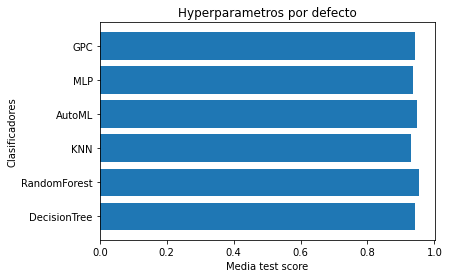

In [54]:
fig, op = plt.subplots()

classificadores = ("DecisionTree","RandomForest","KNN","AutoML","MLP","GPC")
resultados = (accuracy_tree_df,accuracy_forest_df,accuracy_knn_df,accuracy_automl,accuracy_mlp_df,accuracy_gpc_df)
op.barh(classificadores,resultados,align='center')
op.set_yticklabels(classificadores)
op.set_xlabel("Media test score")
op.set_ylabel("Clasificadores")
op.set_title("Hyperparametros por defecto")

plt.show()

Hacer grafico de comparativa de los resultados defecto y optimizado

<ipython-input-55-a312aca3f60e>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  op2.set_yticklabels(classificadores)


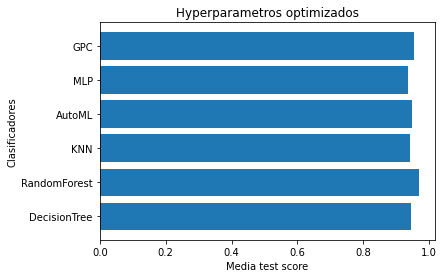

In [55]:
fig2, op2 = plt.subplots()

resultados = (tree_new_mean,forest_new_mean,knn_new_mean,accuracy_automl,mlp_new_mean,gpc_new_mean)
op2.barh(classificadores,resultados,align='center')
op2.set_yticklabels(classificadores)
op2.set_xlabel("Media test score")
op2.set_ylabel("Clasificadores")
op2.set_title("Hyperparametros optimizados")

plt.show()

[Text(139.5, 199.32, 'X[22] <= 104.95\ngini = 0.468\nsamples = 398\nvalue = [149, 249]'),
 Text(63.77142857142857, 163.07999999999998, 'X[27] <= 0.135\ngini = 0.049\nsamples = 237\nvalue = [6, 231]'),
 Text(31.885714285714286, 126.83999999999999, 'X[10] <= 0.643\ngini = 0.009\nsamples = 225\nvalue = [1, 224]'),
 Text(15.942857142857143, 90.6, 'gini = 0.0\nsamples = 222\nvalue = [0, 222]'),
 Text(47.82857142857143, 90.6, 'X[16] <= 0.017\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(31.885714285714286, 54.359999999999985, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(63.77142857142857, 54.359999999999985, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(95.65714285714286, 126.83999999999999, 'X[21] <= 26.9\ngini = 0.486\nsamples = 12\nvalue = [5, 7]'),
 Text(79.71428571428572, 90.6, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(111.6, 90.6, 'X[19] <= 0.003\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(95.65714285714286, 54.359999999999985, 'gini = 0.0\nsamples = 1\nv

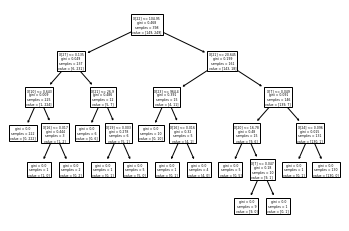

In [56]:
tree.plot_tree(dtree2)